In [ ]:
cat_directory = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [ ]:
cat_directory = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat.head(10)

In [8]:
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f');
arrival_time

datetime.datetime(1970, 6, 26, 20, 1)

In [9]:
arrival_time_relative = row['time_rel(sec)']
arrival_time_relative

72060.0

In [10]:
file_name = row['filename']
file_name

'xa.s12.00.mhz.1970-06-26HR00_evid00009'

In [ ]:
data_directory = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{file_name}.csv'
data_cat = pd.read_csv(csv_file)
data_cat.head(10)

In [ ]:
csv_relative_times = np.array(data_cat['time_rel(sec)'])
csv_velocity_data = np.array(data_cat['velocity(m/s)'])

csv_relative_times
csv_velocity_data

In [ ]:
plt.plot(csv_relative_times, csv_velocity_data)

In [14]:
data_directory = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{file_name}.mseed'
stream_data_from_sensor = read(mseed_file)
stream_data_from_sensor.traces[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-06-26T00:00:00.116000Z
         endtime: 1970-06-27T00:00:03.436755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

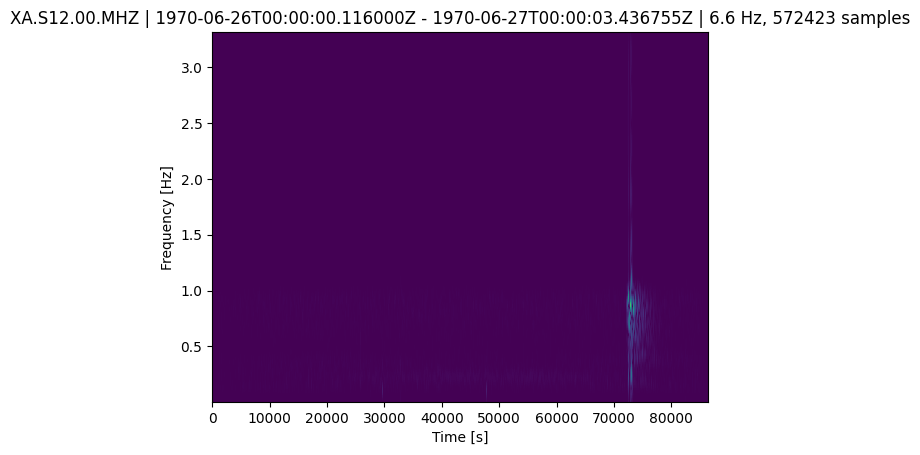

In [15]:
stream_data_from_sensor.traces[0].spectrogram()

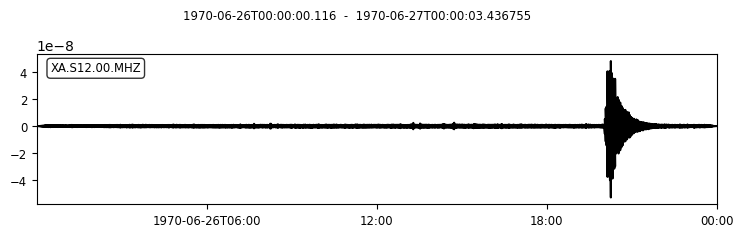

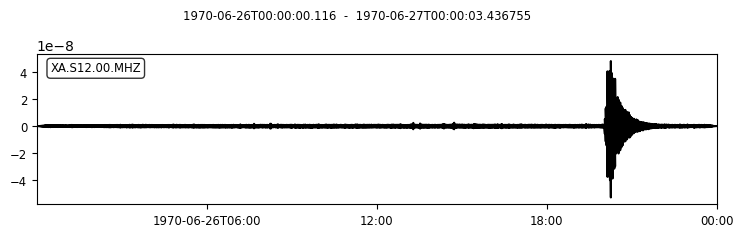

In [16]:
stream_data_from_sensor.traces[0].plot()

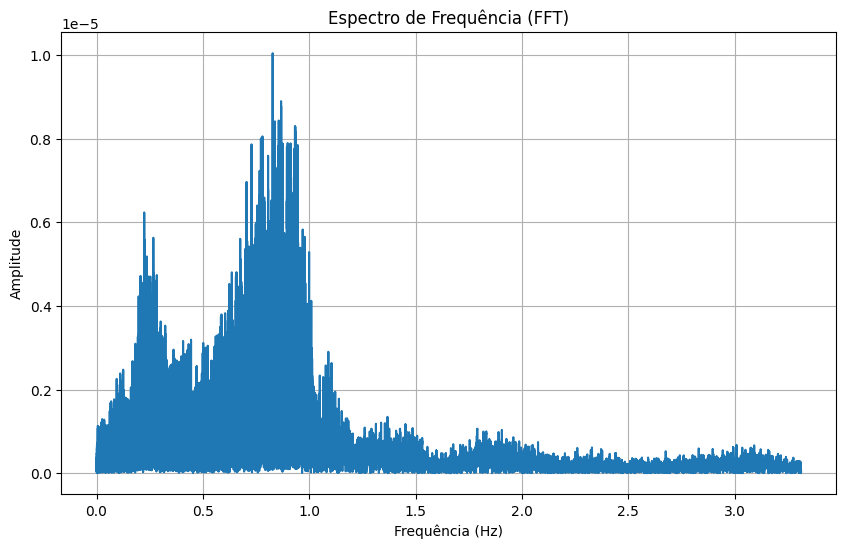

In [17]:
import numpy as np
import matplotlib.pyplot as plt

my_trace_data = stream_data_from_sensor.traces[0].data
my_trace_sampling_rate = stream_data_from_sensor.traces[0].stats.sampling_rate

# Realizar a FFT
fft_values = np.fft.fft(my_trace_data)

# Calcular as frequências correspondentes
frequencies = np.fft.fftfreq(len(my_trace_data), d=1/my_trace_sampling_rate)

# Apenas a metade positiva (porque a FFT resulta em frequências simétricas)
positive_freqs = frequencies[:len(frequencies)//2]
positive_fft_values = np.abs(fft_values[:len(fft_values)//2])

# Plotar o espectro de frequências
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_values)
plt.title("Espectro de Frequência (FFT)")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

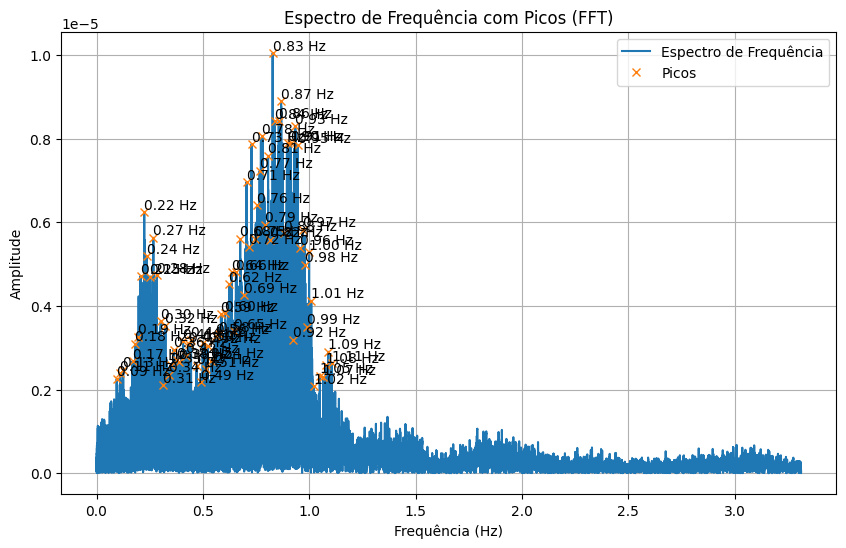

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Manter apenas a metade positiva
positive_freqs = frequencies[:len(frequencies)//2]
positive_fft_values = np.abs(fft_values[:len(fft_values)//2])

# Encontrar os picos (frequências proeminentes)
# Você pode ajustar a altura mínima ou a distância mínima entre os picos
peaks, _ = find_peaks(positive_fft_values, height=(0.2e-5, 2e-5), 
                      distance=0.01 * len(my_trace_data) / my_trace_sampling_rate)

# Plotar o espectro de frequência
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_values, label='Espectro de Frequência')

# Plotar os picos
plt.plot(positive_freqs[peaks], positive_fft_values[peaks], "x", label='Picos')

# Destacar os picos no gráfico
for peak in peaks:
    plt.text(positive_freqs[peak], positive_fft_values[peak], 
             f'{positive_freqs[peak]:.2f} Hz', 
             horizontalalignment='left', verticalalignment='bottom')

plt.title("Espectro de Frequência com Picos (FFT)")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


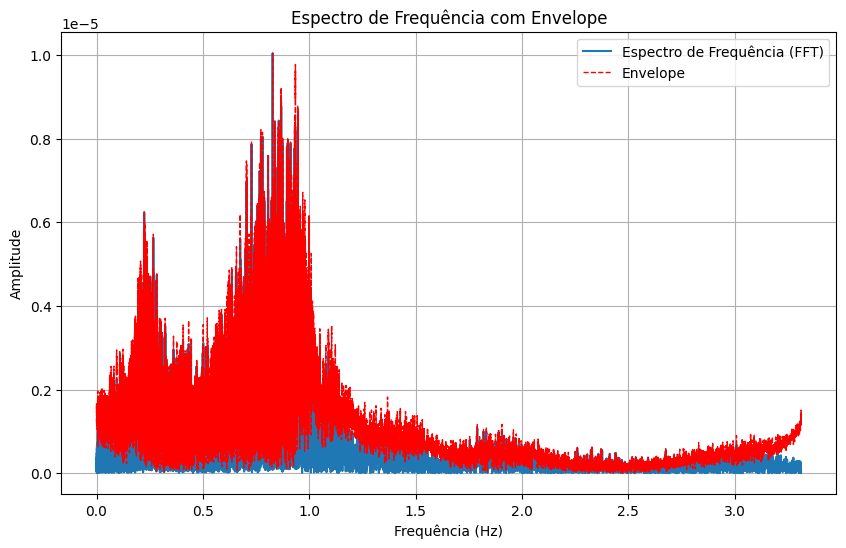

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Aplicar a Transformada de Hilbert para obter o envelope
hilbert_transform = hilbert(positive_fft_values)
envelope = np.abs(hilbert_transform)

# Plotar o espectro de frequência
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft_values, label='Espectro de Frequência (FFT)')

# Plotar o envelope com uma linha tênue e pontilhada
plt.plot(positive_freqs, envelope, label='Envelope', linestyle='--', color='red', linewidth=1)

plt.title("Espectro de Frequência com Envelope")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()

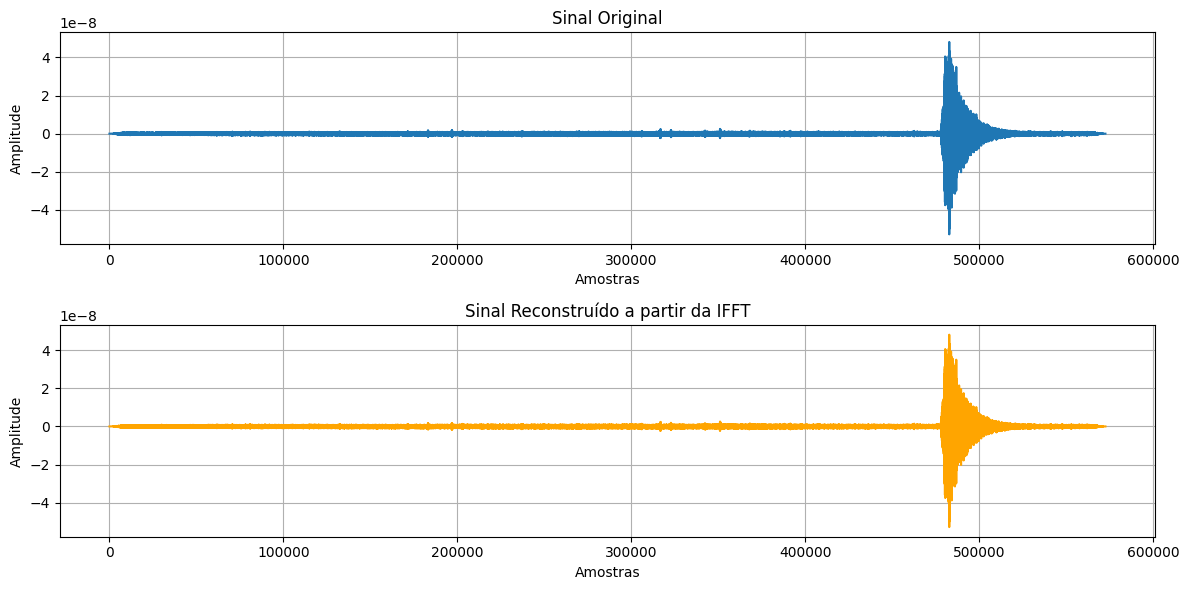

In [20]:
# Aplicar a IFFT para reconstruir o sinal original
reconstructed_signal = np.fft.ifft(fft_values)

# Como a IFFT pode retornar números complexos devido a erros numéricos,
# tomamos apenas a parte real do sinal reconstruído
reconstructed_signal = np.real(reconstructed_signal)

# Plotar o sinal original e o sinal reconstruído
plt.figure(figsize=(12, 6))

# Sinal original
plt.subplot(2, 1, 1)
plt.plot(my_trace_data, label="Sinal Original")
plt.title("Sinal Original")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.grid()

# Sinal reconstruído
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label="Sinal Reconstruído", color='orange')
plt.title("Sinal Reconstruído a partir da IFFT")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

# Caminho da pasta que contém os arquivos .mseed
data_directory = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/'

# Lista todos os arquivos .mseed na pasta
files = [f for f in os.listdir(data_directory) if f.endswith('.mseed')]

# Iterar sobre cada arquivo .mseed
for mseed_file in files:
    full_path = os.path.join(data_directory, mseed_file)
    
    # Ler o arquivo .mseed
    stream_data_from_sensor = read(full_path)
    stream_data_from_sensor.traces[0].stats
    
    # Gerar os gráficos
    print(f"Analisando o arquivo: {mseed_file}")
    
    # Gerar o espectrograma
    stream_data_from_sensor.traces[0].spectrogram()
    
    # Plotar o gráfico do sinal temporal
    stream_data_from_sensor.traces[0].plot()
    
    # Dados da FFT
    my_trace_data = stream_data_from_sensor.traces[0].data
    my_trace_sampling_rate = stream_data_from_sensor.traces[0].stats.sampling_rate
    
    # Realizar a FFT
    fft_values = np.fft.fft(my_trace_data)
    
    # Calcular as frequências correspondentes
    frequencies = np.fft.fftfreq(len(my_trace_data), d=1/my_trace_sampling_rate)
    
    # Apenas a metade positiva (porque a FFT resulta em frequências simétricas)
    positive_freqs = frequencies[:len(frequencies)//2]
    positive_fft_values = np.abs(fft_values[:len(fft_values)//2])
    
    # Plotar o espectro de frequências
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_fft_values)
    plt.title(f"Espectro de Frequência (FFT) - {mseed_file}")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()
    
    # Aguardar o usuário pressionar Enter para ir para o próximo arquivo
    input("Pressione Enter para continuar para o próximo arquivo...")


ModuleNotFoundError: No module named 'obspy'

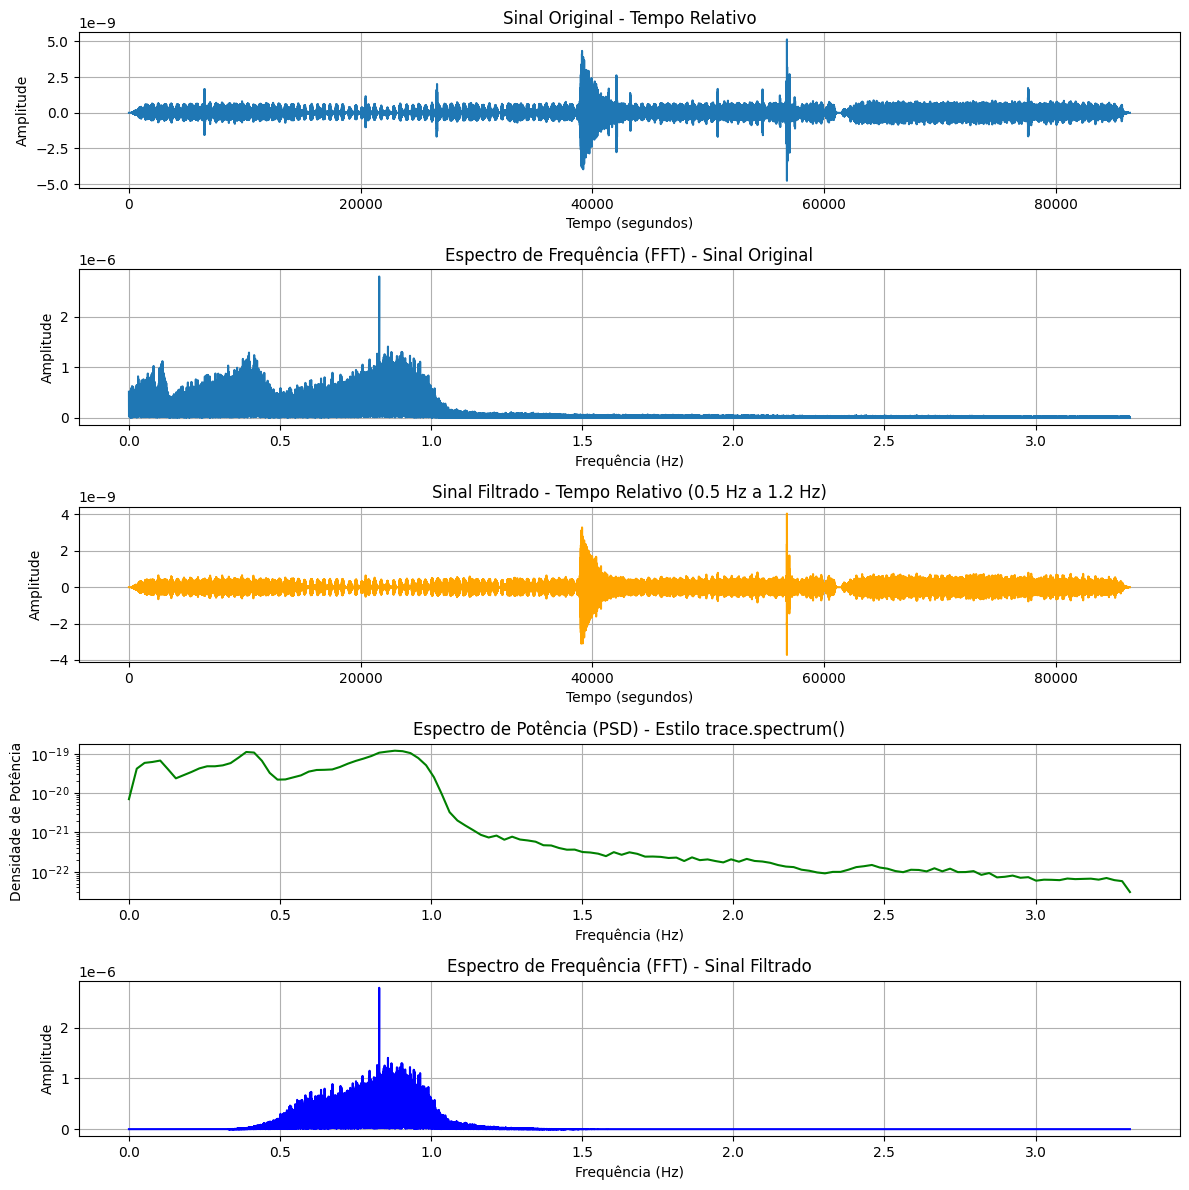

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from obspy import read

# Função para criar e aplicar um filtro Butterworth passa-banda
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Caminho do arquivo .mseed
mseed_file = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed'

# Ler o arquivo .mseed
stream_data_from_sensor = read(mseed_file)
trace = stream_data_from_sensor.traces[0]
sampling_rate = trace.stats.sampling_rate
time = np.arange(0, len(trace.data)) / sampling_rate  # Criar um eixo de tempo relativo

# Parâmetros do filtro passa-banda (0.5 Hz a 1.2 Hz)
lowcut = 0.5  # Frequência de corte inferior
highcut = 1.2  # Frequência de corte superior

# Aplicar o filtro passa-banda
filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

# ----------------------- Gráficos -----------------------
plt.figure(figsize=(12, 12))

# 1. Gráfico do sinal original no tempo (em tempo relativo)
plt.subplot(5, 1, 1)
plt.plot(time, trace.data, label='Sinal Original')
plt.title("Sinal Original - Tempo Relativo")
plt.xlabel("Tempo (segundos)")
plt.ylabel("Amplitude")
plt.grid()

# 2. Espectro de frequência do sinal original (FFT)
fft_values = np.fft.fft(trace.data)
frequencies = np.fft.fftfreq(len(trace.data), d=1/sampling_rate)
positive_freqs = frequencies[:len(frequencies)//2]
positive_fft_values = np.abs(fft_values[:len(frequencies)//2])

plt.subplot(5, 1, 2)
plt.plot(positive_freqs, positive_fft_values, label='Espectro de Frequência (FFT)')
plt.title("Espectro de Frequência (FFT) - Sinal Original")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Amplitude")
plt.grid()

# 3. Gráfico do sinal filtrado (dados filtrados no tempo relativo)
plt.subplot(5, 1, 3)
plt.plot(time, filtered_data, label='Sinal Filtrado (0.5 Hz a 1.2 Hz)', color='orange')
plt.title("Sinal Filtrado - Tempo Relativo (0.5 Hz a 1.2 Hz)")
plt.xlabel("Tempo (segundos)")
plt.ylabel("Amplitude")
plt.grid()

# 4. Espectro de Potência (Estilo trace.spectrum())
frequencies_psd, power_spectral_density = welch(trace.data, fs=sampling_rate, nperseg=256)

plt.subplot(5, 1, 4)
plt.semilogy(frequencies_psd, power_spectral_density, label='Espectro de Potência (PSD)', color='green')
plt.title("Espectro de Potência (PSD) - Estilo trace.spectrum()")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Densidade de Potência")
plt.grid()

# 5. Espectro de Frequência (FFT) do sinal filtrado
fft_filtered = np.fft.fft(filtered_data)
positive_fft_filtered = np.abs(fft_filtered[:len(frequencies)//2])

plt.subplot(5, 1, 5)
plt.plot(positive_freqs, positive_fft_filtered, label='Espectro de Frequência (FFT) - Sinal Filtrado', color='blue')
plt.title("Espectro de Frequência (FFT) - Sinal Filtrado")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()


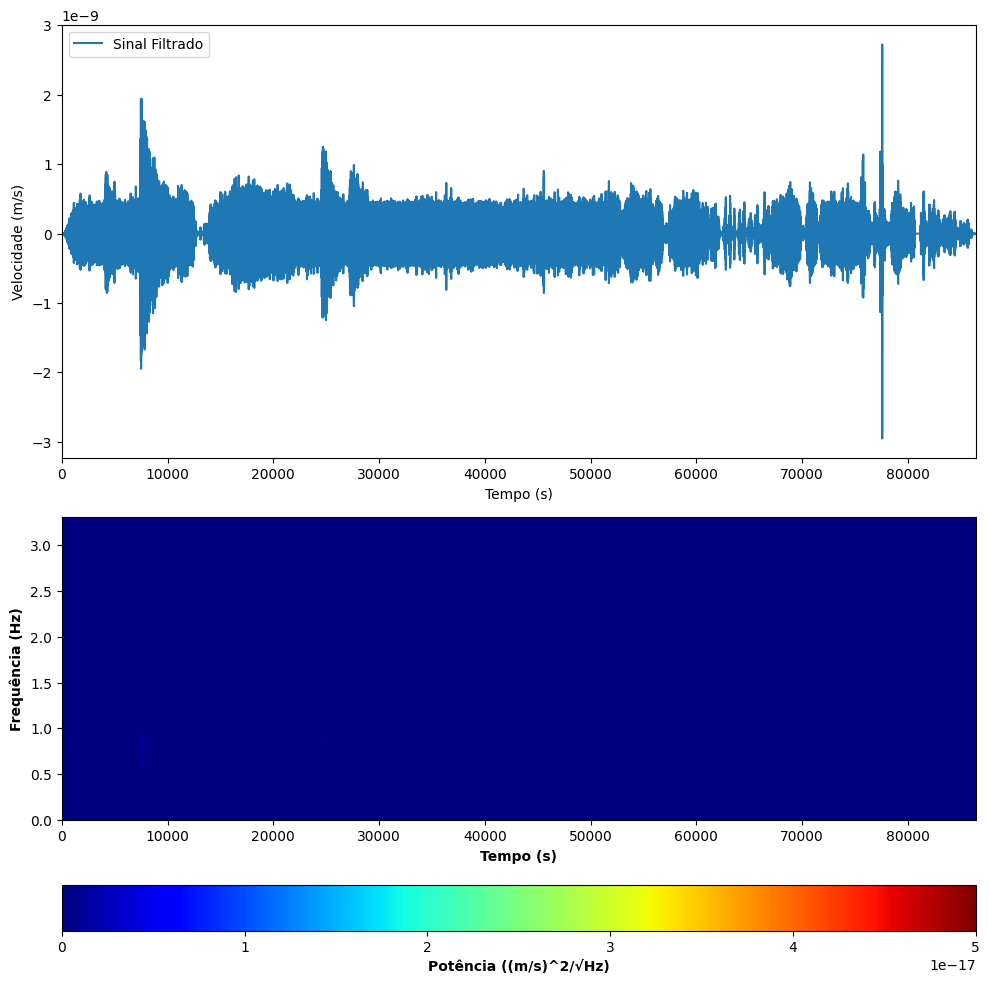

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, spectrogram
from obspy import read
from matplotlib import cm

# Função para criar e aplicar um filtro Butterworth passa-banda
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Caminho do arquivo .mseed
mseed_file = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed'

# Ler o arquivo .mseed
stream_data_from_sensor = read(mseed_file)
trace = stream_data_from_sensor.traces[0]
sampling_rate = trace.stats.sampling_rate
time = np.arange(0, len(trace.data)) / sampling_rate  # Criar um eixo de tempo relativo

# Parâmetros do filtro passa-banda (0.5 Hz a 1.2 Hz)
lowcut = 0.5  # Frequência de corte inferior
highcut = 1.2  # Frequência de corte superior

# Aplicar o filtro passa-banda
filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

# Definir um "arrival time" (exemplo arbitrário)
arrival = 100  # Ponto no tempo de chegada do evento sísmico

# ----------------------- Cálculo do Espectrograma -----------------------
# Usar a função spectrogram da SciPy para criar o espectrograma
frequencies, times, sxx = spectrogram(filtered_data, fs=sampling_rate)

# ----------------------- Gráficos -----------------------
fig = plt.figure(figsize=(10, 10))

# 1. Plot do sinal filtrado no tempo
ax = plt.subplot(2, 1, 1)
ax.plot(time, filtered_data, label='Sinal Filtrado')
ax.legend(loc='upper left')

# Tornar o gráfico mais bonito
ax.set_xlim([min(time), max(time)])
ax.set_ylabel('Velocidade (m/s)')
ax.set_xlabel('Tempo (s)')

# 2. Plot do Espectrograma
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(times, frequencies, sxx, cmap=cm.jet, shading='gouraud', vmax=5e-17)

# Ajustes no espectrograma
ax2.set_xlim([min(time), max(time)])
ax2.set_xlabel('Tempo (s)', fontweight='bold')
ax2.set_ylabel('Frequência (Hz)', fontweight='bold')

# Barra de cores para representar a potência do espectrograma
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Potência ((m/s)^2/√Hz)', fontweight='bold')

plt.tight_layout()
plt.show()


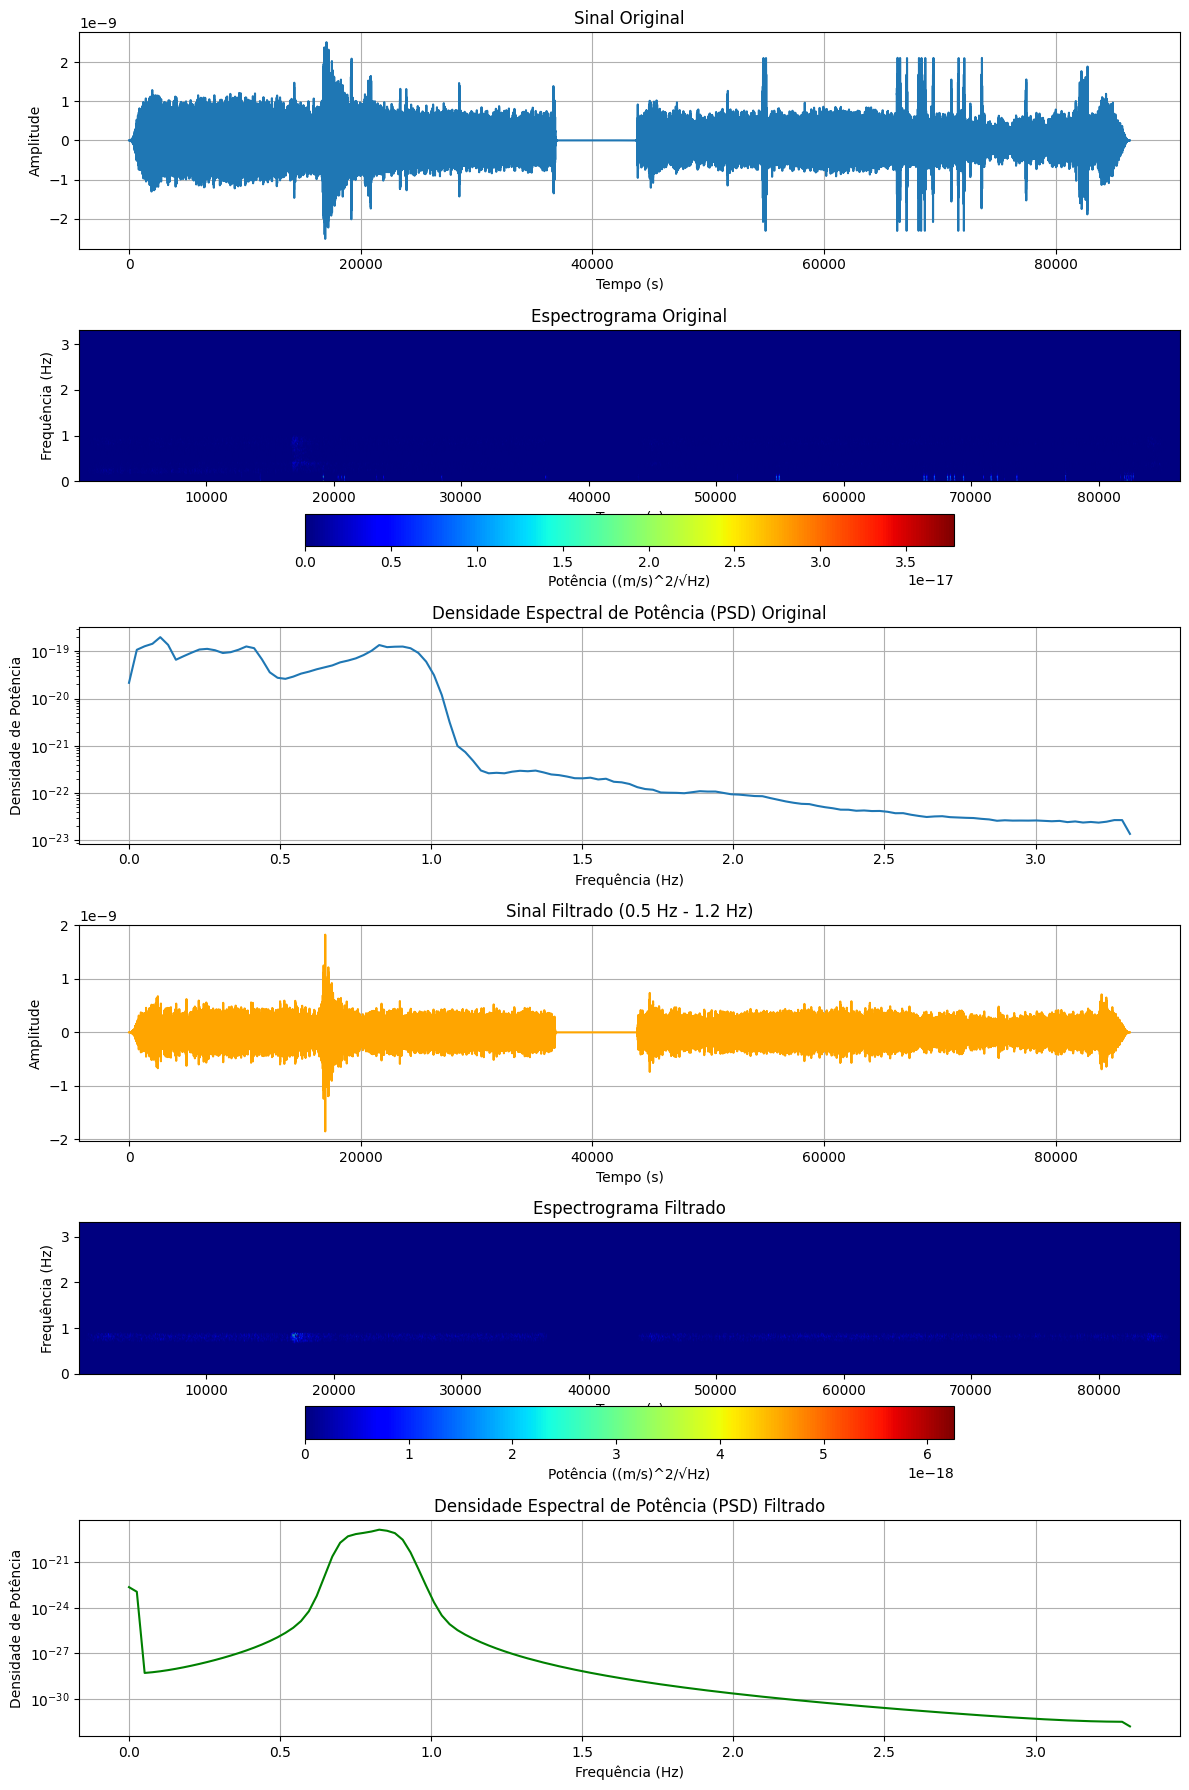

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, spectrogram
from obspy import read
from matplotlib import cm

# Função para criar e aplicar um filtro Butterworth passa-banda
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Caminho do arquivo .mseed
mseed_file = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-24HR00_evid00028.mseed'

# Ler o arquivo .mseed
stream_data_from_sensor = read(mseed_file)
trace = stream_data_from_sensor.traces[0]
sampling_rate = trace.stats.sampling_rate
time = np.arange(0, len(trace.data)) / sampling_rate  # Criar um eixo de tempo relativo

# Parâmetros do filtro passa-banda (0.5 Hz a 1.2 Hz)
lowcut = 0.7  # Frequência de corte inferior
highcut = 0.9  # Frequência de corte superior

# Aplicar o filtro passa-banda ao sinal
filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

# ----------------------- Cálculo do Espectrograma e PSD -----------------------
# Espectrograma para o sinal original
frequencies_orig, times_orig, sxx_orig = spectrogram(trace.data, fs=sampling_rate)

# Espectrograma para o sinal filtrado
frequencies_filt, times_filt, sxx_filt = spectrogram(filtered_data, fs=sampling_rate)

# PSD (Densidade Espectral de Potência) para o sinal original
frequencies_psd_orig, psd_orig = welch(trace.data, fs=sampling_rate, nperseg=256)

# PSD (Densidade Espectral de Potência) para o sinal filtrado
frequencies_psd_filt, psd_filt = welch(filtered_data, fs=sampling_rate, nperseg=256)

# ----------------------- Gráficos -----------------------
fig, axs = plt.subplots(6, 1, figsize=(12, 18))

# 1. Sinal Original no tempo
axs[0].plot(time, trace.data, label='Sinal Original')
axs[0].set_title('Sinal Original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# 2. Espectrograma Original
vals = axs[1].pcolormesh(times_orig, frequencies_orig, sxx_orig, cmap=cm.jet, shading='gouraud')
axs[1].set_title('Espectrograma Original')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequência (Hz)')
cbar = plt.colorbar(vals, ax=axs[1], orientation='horizontal')
cbar.set_label('Potência ((m/s)^2/√Hz)')

# 3. PSD Original
axs[2].semilogy(frequencies_psd_orig, psd_orig, label='PSD Original')
axs[2].set_title('Densidade Espectral de Potência (PSD) Original')
axs[2].set_xlabel('Frequência (Hz)')
axs[2].set_ylabel('Densidade de Potência')
axs[2].grid(True)

# 4. Sinal Filtrado no tempo
axs[3].plot(time, filtered_data, label='Sinal Filtrado', color='orange')
axs[3].set_title('Sinal Filtrado (0.5 Hz - 1.2 Hz)')
axs[3].set_xlabel('Tempo (s)')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)

# 5. Espectrograma Filtrado
vals_filt = axs[4].pcolormesh(times_filt, frequencies_filt, sxx_filt, cmap=cm.jet, shading='gouraud')
axs[4].set_title('Espectrograma Filtrado')
axs[4].set_xlabel('Tempo (s)')
axs[4].set_ylabel('Frequência (Hz)')
cbar_filt = plt.colorbar(vals_filt, ax=axs[4], orientation='horizontal')
cbar_filt.set_label('Potência ((m/s)^2/√Hz)')

# 6. PSD Filtrado
axs[5].semilogy(frequencies_psd_filt, psd_filt, label='PSD Filtrado', color='green')
axs[5].set_title('Densidade Espectral de Potência (PSD) Filtrado')
axs[5].set_xlabel('Frequência (Hz)')
axs[5].set_ylabel('Densidade de Potência')
axs[5].grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, spectrogram
from obspy import read
from matplotlib import cm

# Função para criar e aplicar um filtro Butterworth passa-banda
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Caminho do arquivo .mseed
# mseed_file = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1977-04-24HR00_evid00923.mseed'
mseed_file = '/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-18HR00_evid00036.mseed'

# Ler o arquivo .mseed
stream_data_from_sensor = read(mseed_file)
trace = stream_data_from_sensor.traces[0]
sampling_rate = trace.stats.sampling_rate
time = np.arange(0, len(trace.data)) / sampling_rate  # Criar um eixo de tempo relativo

# Parâmetros do filtro passa-banda (0.5 Hz a 1.2 Hz)
lowcut = 0.7  # Frequência de corte inferior
highcut = 0.9  # Frequência de corte superior

# Aplicar o filtro passa-banda ao sinal
filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

# ----------------------- Cálculo do Espectrograma e PSD -----------------------
# Espectrograma para o sinal original
frequencies_orig, times_orig, sxx_orig = spectrogram(trace.data, fs=sampling_rate)

# Espectrograma para o sinal filtrado
frequencies_filt, times_filt, sxx_filt = spectrogram(filtered_data, fs=sampling_rate)

# PSD (Densidade Espectral de Potência) para o sinal original
frequencies_psd_orig, psd_orig = welch(trace.data, fs=sampling_rate, nperseg=256)

# PSD (Densidade Espectral de Potência) para o sinal filtrado
frequencies_psd_filt, psd_filt = welch(filtered_data, fs=sampling_rate, nperseg=256)

# ----------------------- Gráficos -----------------------
fig, axs = plt.subplots(6, 1, figsize=(12, 18))

# Ajustar o limite de tempo para todos os gráficos
x_min, x_max = min(time), max(time)

# 1. Sinal Original no tempo
axs[0].plot(time, trace.data, label='Sinal Original')
axs[0].set_title('Sinal Original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)
axs[0].set_xlim(x_min, x_max)

# 2. Espectrograma Original
vals = axs[1].pcolormesh(times_orig, frequencies_orig, sxx_orig, cmap=cm.jet, shading='gouraud')
axs[1].set_title('Espectrograma Original')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequência (Hz)')
axs[1].set_xlim(x_min, x_max)
cbar = plt.colorbar(vals, ax=axs[1], orientation='horizontal')
cbar.set_label('Potência ((m/s)^2/√Hz)')

# 3. PSD Original
axs[2].semilogy(frequencies_psd_orig, psd_orig, label='PSD Original')
axs[2].set_title('Densidade Espectral de Potência (PSD) Original')
axs[2].set_xlabel('Frequência (Hz)')
axs[2].set_ylabel('Densidade de Potência')
axs[2].grid(True)

# 4. Sinal Filtrado no tempo
axs[3].plot(time, filtered_data, label='Sinal Filtrado', color='orange')
axs[3].set_title(f'Sinal Filtrado ({lowcut} Hz - {highcut} Hz)')
axs[3].set_xlabel('Tempo (s)')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)
axs[3].set_xlim(x_min, x_max)

# 5. Espectrograma Filtrado
vals_filt = axs[4].pcolormesh(times_filt, frequencies_filt, sxx_filt, cmap=cm.jet, shading='gouraud')
axs[4].set_title('Espectrograma Filtrado')
axs[4].set_xlabel('Tempo (s)')
axs[4].set_ylabel('Frequência (Hz)')
axs[4].set_xlim(x_min, x_max)
cbar_filt = plt.colorbar(vals_filt, ax=axs[4], orientation='horizontal')
cbar_filt.set_label('Potência ((m/s)^2/√Hz)')

# 6. PSD Filtrado
axs[5].semilogy(frequencies_psd_filt, psd_filt, label='PSD Filtrado', color='green')
axs[5].set_title('Densidade Espectral de Potência (PSD) Filtrado')
axs[5].set_xlabel('Frequência (Hz)')
axs[5].set_ylabel('Densidade de Potência')
axs[5].grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-18HR00_evid00036.mseed'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram
from obspy import read
from skimage.feature import peak_local_max
from matplotlib import cm

# Função para criar e aplicar um filtro Butterworth passa-banda
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Caminho do arquivo .mseed
mseed_file = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-07-18HR00_evid00036.mseed'

# Ler o arquivo .mseed
stream_data_from_sensor = read(mseed_file)
trace = stream_data_from_sensor.traces[0]
sampling_rate = trace.stats.sampling_rate

# Filtrar o sinal
lowcut = 0.7  # Frequência de corte inferior
highcut = 0.9  # Frequência de corte superior
filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

# Calcular o Espectrograma
frequencies, times, sxx = spectrogram(filtered_data, fs=sampling_rate)

# Localizar picos no espectrograma usando a função peak_local_max
# threshold_rel define o nível mínimo relativo para considerar um pico
peaks = peak_local_max(sxx, min_distance=5, threshold_rel=0.6)  # Ajuste o threshold para maior sensibilidade

# ----------------------- Gráfico -----------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Espectrograma Filtrado
vals = ax.pcolormesh(times, frequencies, sxx, cmap=cm.jet, shading='gouraud')
ax.set_title('Espectrograma Filtrado')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Frequência (Hz)')
cbar = plt.colorbar(vals, ax=ax)
cbar.set_label('Potência ((m/s)^2/√Hz)')

# Plotar os picos (centros das "bolinhas")
peak_times = times[peaks[:, 1]]
peak_frequencies = frequencies[peaks[:, 0]]

ax.plot(peak_times, peak_frequencies, 'ro', label='Centros de Alta Densidade')
ax.legend()

plt.show()


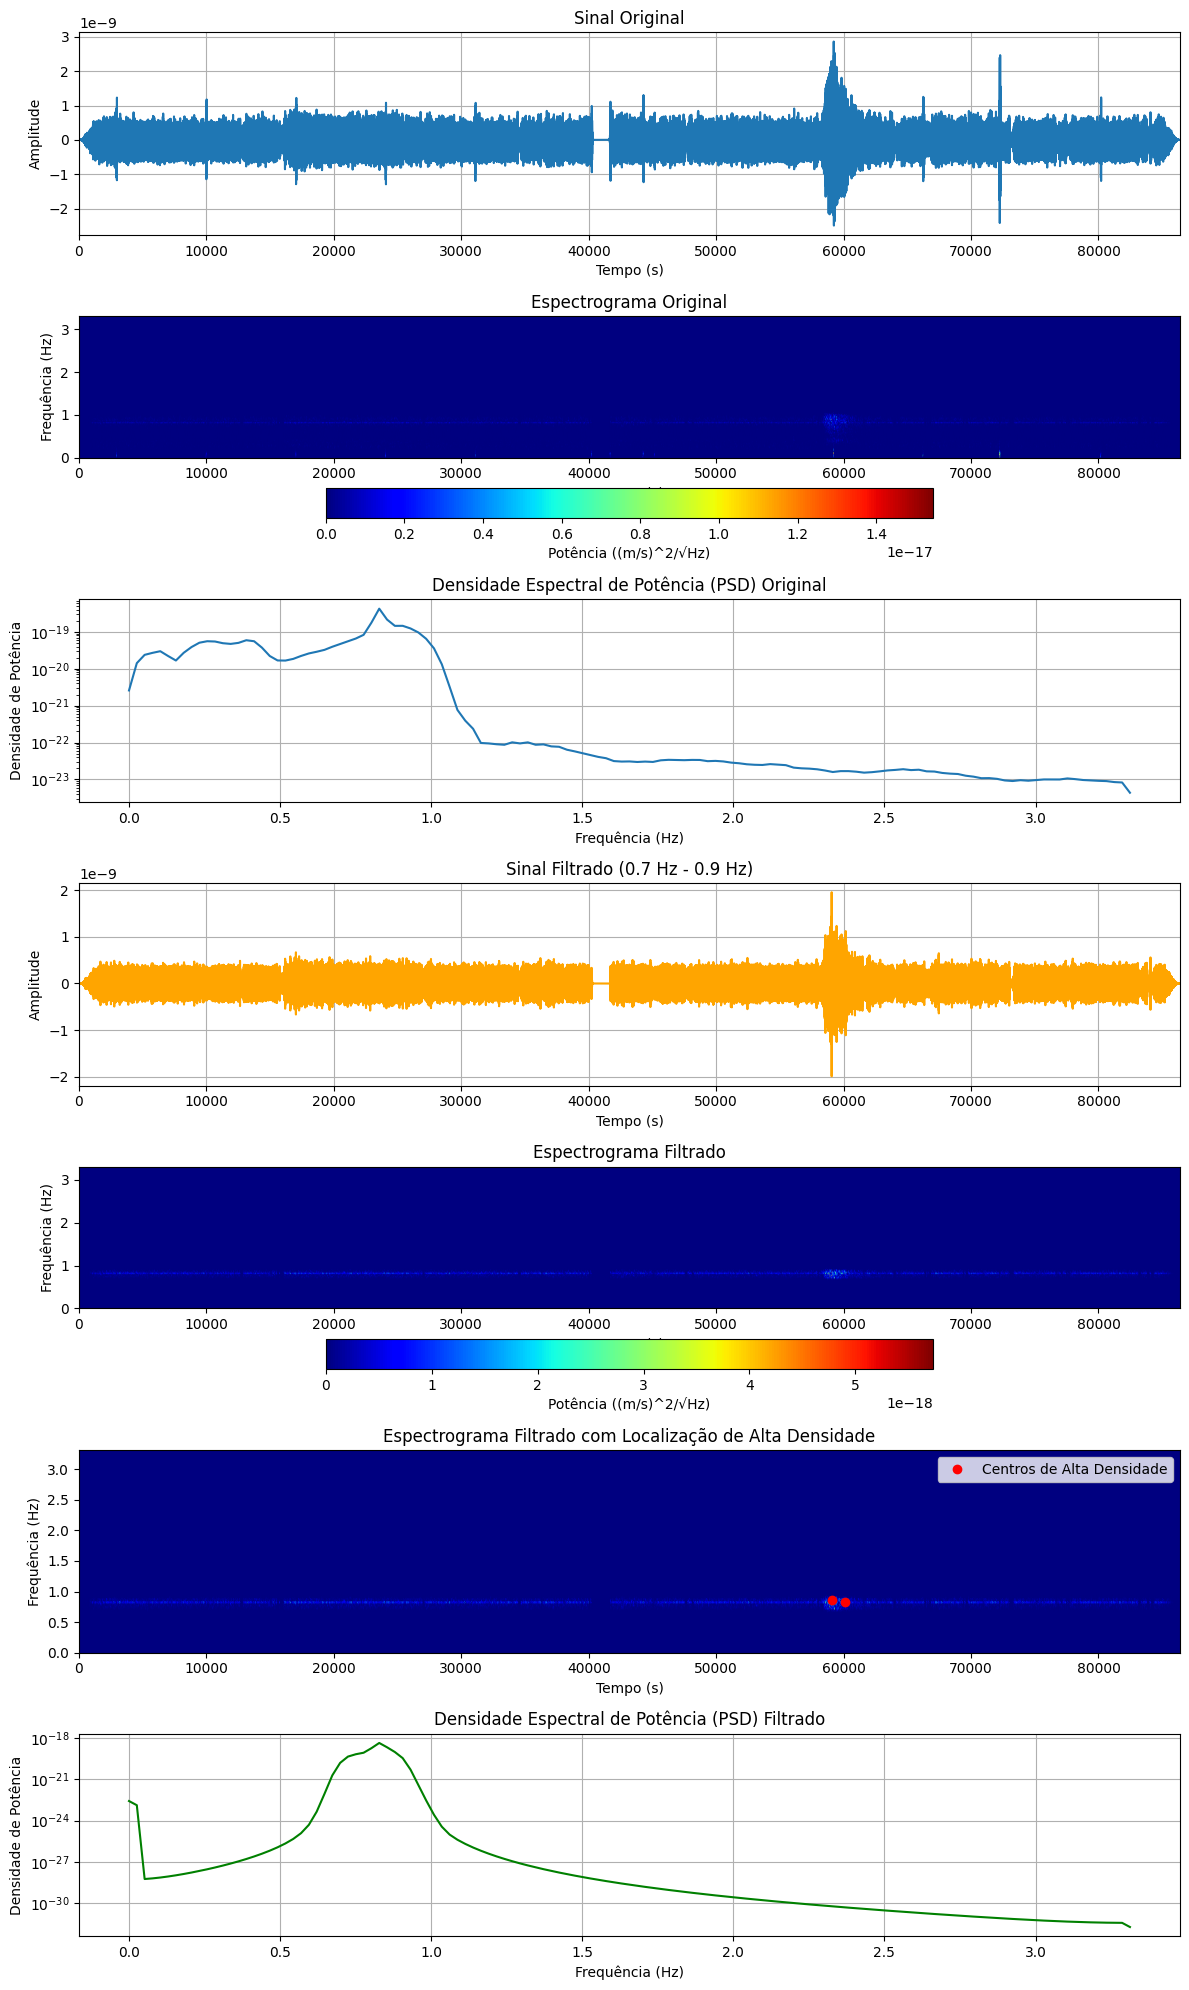

In [35]:
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram
from obspy import read
from skimage.feature import peak_local_max
import struct
import os
from datetime import datetime, timedelta

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def process_seismic_file(mseed_file):
    # Read the .mseed file
    stream_data_from_sensor = read(mseed_file)
    trace = stream_data_from_sensor.traces[0]
    sampling_rate = trace.stats.sampling_rate
    start_time = trace.stats.starttime

    # Filter the signal
    lowcut, highcut = 0.7, 0.9
    filtered_data = apply_bandpass_filter(trace.data, lowcut, highcut, sampling_rate)

    # Calculate the spectrogram
    frequencies, times, sxx = spectrogram(filtered_data, fs=sampling_rate)

    # Find peaks in the spectrogram
    peaks = peak_local_max(sxx, min_distance=5, threshold_rel=0.6)

    # Determine start and end time of the seismic event
    if len(peaks) > 0:
        event_start = start_time + timedelta(seconds=times[peaks[0][1]])
        event_end = start_time + timedelta(seconds=times[peaks[-1][1]])
    else:
        event_start = event_end = start_time

    # Extract peak frequencies and times
    peak_times = [start_time + timedelta(seconds=t) for t in times[peaks[:, 1]]]
    peak_frequencies = frequencies[peaks[:, 0]]

    return {
        'filename': os.path.basename(mseed_file),
        'start_time': event_start.isoformat(),
        'end_time': event_end.isoformat(),
        'peak_times': [t.isoformat() for t in peak_times],
        'peak_frequencies': peak_frequencies.tolist()
    }

def write_summary_to_file(summary_data, output_file):
    with open(output_file, 'wb') as f:
        for data in summary_data:
            # Write filename (null-terminated string)
            f.write(data['filename'].encode() + b'\0')
            
            # Write start and end times (as null-terminated strings)
            f.write(data['start_time'].encode() + b'\0')
            f.write(data['end_time'].encode() + b'\0')
            
            # Write number of peaks
            num_peaks = len(data['peak_times'])
            f.write(struct.pack('I', num_peaks))
            
            # Write peak times and frequencies
            for time, freq in zip(data['peak_times'], data['peak_frequencies']):
                f.write(time.encode() + b'\0')
                f.write(struct.pack('f', freq))

# Process all .mseed files in the directory
data_directory = 'data/lunar/test/data/S12_GradeB/'
summary_data = []

for filename in os.listdir(data_directory):
    if filename.endswith('.mseed'):
        mseed_file = os.path.join(data_directory, filename)
        summary_data.append(process_seismic_file(mseed_file))

# Write summary data to binary file
output_file = 'seismic_summary.bin'
write_summary_to_file(summary_data, output_file)

print(f"Summary data for {len(summary_data)} files saved to {output_file}")

Summary data for 64 files saved to seismic_summary.bin


In [36]:
def read_summary_file(filename):
    with open(filename, 'rb') as f:
        while True:
            # Read filename
            filename = read_null_terminated_string(f)
            if not filename:
                return  # End of file

            # Read start and end times
            start_time = read_null_terminated_string(f)
            end_time = read_null_terminated_string(f)

            # Read number of peaks
            num_peaks = struct.unpack('I', f.read(4))[0]

            # Read peak times and frequencies
            peaks = []
            for _ in range(num_peaks):
                time = read_null_terminated_string(f)
                freq = struct.unpack('f', f.read(4))[0]
                peaks.append((time, freq))

            yield {
                'filename': filename,
                'start_time': start_time,
                'end_time': end_time,
                'peaks': peaks
            }

def read_null_terminated_string(file):
    result = b''
    char = file.read(1)
    while char != b'\0':
        if not char:  # End of file
            return None
        result += char
        char = file.read(1)
    return result.decode()

# Usage
for summary in read_summary_file('seismic_summary.bin'):
    print(f"File: {summary['filename']}")
    print(f"Event time: {summary['start_time']} to {summary['end_time']}")
    print(f"Number of peaks: {len(summary['peaks'])}")
    print(f"First 5 peaks: {summary['peaks'][:5]}")
    print()

File: xa.s12.00.mhz.1971-10-26HR00_evid00133.mseed
Event time: 1971-10-26T04:49:25.110302 to 1971-10-26T04:58:26.091434
Number of peaks: 3
First 5 peaks: [('1971-10-26T04:49:25.110302', 0.85400390625), ('1971-10-26T04:44:54.619736', 0.828125), ('1971-10-26T04:58:26.091434', 0.828125)]

File: xa.s12.00.mhz.1974-10-02HR00_evid00572.mseed
Event time: 1974-10-02T13:35:44.571887 to 1974-10-02T13:43:37.930377
Number of peaks: 2
First 5 peaks: [('1974-10-02T13:35:44.571887', 0.85400390625), ('1974-10-02T13:43:37.930377', 0.828125)]

File: xa.s12.00.mhz.1972-11-19HR00_evid00335.mseed
Event time: 1972-11-19T18:39:29.279774 to 1972-11-19T18:32:43.543925
Number of peaks: 2
First 5 peaks: [('1972-11-19T18:39:29.279774', 0.828125), ('1972-11-19T18:32:43.543925', 0.8798828125)]

File: xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed
Event time: 1970-03-14T12:25:52.218113 to 1970-03-14T09:22:43.538868
Number of peaks: 20
First 5 peaks: [('1970-03-14T12:25:52.218113', 0.7763671875), ('1970-03-14T18:23:42.